In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from datetime import datetime
from scipy.stats import moment
from copy import deepcopy
from tqdm import tqdm
import pickle

import sys
from os.path import dirname, abspath
import os
sys.path.append(dirname(dirname(abspath('__file__')))+'/utils')

from keras.layers import Dense, LeakyReLU, Conv1D, MaxPooling1D, Flatten, Dropout, Input, Activation, BatchNormalization

from keras.models import Sequential, load_model
from keras.utils import to_categorical
from keras import optimizers
import keras
import tensorflow as tf

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

from matplotlib.patches import Rectangle

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [84]:
input_dfs_split_filename = "raw_subseries_input_dfs_split_30_10.pkl"
indices_filename = "indices_split.pkl"
real_data_al_input_filename = "raw_subseries_input_dfs_real_30_10.pkl"
real_data_al_indices_filename = "indices_real_30_10.pkl"
real_data_ah_input_filename = "raw_subseries_input_dfs_real_30_10_ah.pkl"
real_data_ah_indices_filename = "indices_real_30_10_ah.pkl"

In [85]:
with open(input_dfs_split_filename, "rb") as file:
    X_load = pickle.load(file)
    
with open(input_dfs_split_filename, "rb") as file:
    idx_load = pickle.load(file)
    
with open(real_data_al_input_filename, "rb") as file:
    X_real_al_load = pickle.load(file)   
with open(real_data_al_indices_filename, "rb") as file:
    idx_real_al_load = pickle.load(file)
    
with open(real_data_ah_input_filename, "rb") as file:
    X_real_ah_load = pickle.load(file)   
with open(real_data_ah_indices_filename, "rb") as file:
    idx_real_ah_load = pickle.load(file)

X_train = X_load["train"].copy()
X_test = X_load["test"].copy()
X_val = X_load["val"].copy()

y_train = X_train["label"]
y_test = X_test["label"]
y_val = X_val["label"]

idx_train = idx_load["train"]
idx_test = idx_load["test"]
idx_val = idx_load["val"]


X_real_al = X_real_al_load.copy()
y_real_al = X_real_al["label"]
idx_real_al = idx_real_al_load

X_real_ah = X_real_ah_load.copy()
y_real_ah = X_real_ah["label"]
idx_real_ah = idx_real_ah_load

In [86]:
from sklearn.preprocessing import MinMaxScaler

scaler_train = MinMaxScaler()
scaler_test = MinMaxScaler()
scaler_val = MinMaxScaler()
scaler_real_al = MinMaxScaler()
scaler_real_ah = MinMaxScaler()

cols_to_ignore = ["label", "ts_id", "win_id"]
cols_to_scale = [col for col in X_train.columns if col not in cols_to_ignore]

X_train[cols_to_scale] = scaler_train.fit_transform(X_train[cols_to_scale].T).T
X_test[cols_to_scale] = scaler_test.fit_transform(X_test[cols_to_scale].T).T
X_val[cols_to_scale] = scaler_val.fit_transform(X_val[cols_to_scale].T).T
X_real_al[cols_to_scale] = scaler_real_al.fit_transform(X_real_al[cols_to_scale].T).T
X_real_ah[cols_to_scale] = scaler_real_ah.fit_transform(X_real_ah[cols_to_scale].T).T

In [87]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"./logs/{datetime.now().strftime('%Y%m%d-%H%M%S')}/")
early_stopping_monitor = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=30,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

In [31]:
model = Sequential()
model.add(Input(shape=(30,1)))
model.add(Conv1D(filters=32, kernel_size=7))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv1D(filters=64, kernel_size=5))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=96, kernel_size=5))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Flatten())
# model.add(Dense(512))
# model.add(Dropout(0.3))
# model.add(Activation('relu'))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Activation('relu'))
model.add(Dense(32))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Dense(1, activation='sigmoid'))

adam = optimizers.Adam(lr = 0.0005)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 24, 32)            256       
_________________________________________________________________
batch_normalization_8 (Batch (None, 24, 32)            128       
_________________________________________________________________
activation_16 (Activation)   (None, 24, 32)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 20, 64)            10304     
_________________________________________________________________
batch_normalization_9 (Batch (None, 20, 64)            256       
_________________________________________________________________
activation_17 (Activation)   (None, 20, 64)            0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 10, 64)           

In [71]:
adam = optimizers.Adam(lr = 0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
X_train_ones = X_train[X_train["label"] == 1]
X_train_zeros = X_train[X_train["label"] == 0].sample(n=len(X_train_ones), random_state=133)
X_train_balanced = pd.concat([X_train_zeros, X_train_ones])
y_train_balanced = X_train_balanced["label"]

In [88]:
X_train_inp = X_train_balanced.drop(columns=["ts_id", "win_id", "label"])
X_test_inp = X_test.drop(columns=["ts_id", "win_id", "label"])
X_val_inp = X_val.drop(columns=["ts_id", "win_id", "label"])
X_real_al_inp = X_real_al.drop(columns=["ts_id", "win_id", "label"])
X_real_ah_inp = X_real_ah.drop(columns=["ts_id", "win_id", "label"])

In [11]:
X_train_inp

0         1         2         3         4         5         6   \
25567   0.746203  0.650950  1.000000  0.922133  0.889008  0.550274  0.512186   
19674   0.270818  1.000000  0.409061  0.242261  0.418008  0.586441  0.000000   
69734   0.462774  0.640360  0.611178  0.657474  1.000000  0.584035  0.565815   
7363    0.846418  0.848257  0.854522  0.780330  0.861600  0.912320  1.000000   
58515   0.232666  0.403574  0.409466  0.534699  0.000000  0.606870  0.407930   
...          ...       ...       ...       ...       ...       ...       ...   
195983  0.610113  0.700083  0.609166  0.673342  0.696812  0.715161  0.746824   
195984  0.491440  0.584016  0.668411  0.499022  0.456934  0.473560  0.503944   
195989  0.761905  0.895096  0.726470  0.722822  0.748065  0.700957  0.738581   
195990  0.859864  1.000000  0.503306  0.498333  0.000000  0.627126  0.748883   
195991  1.000000  0.623253  0.436292  0.542598  0.554726  0.459355  0.634184   

              7         8         9   ...        20        21        22  \
25567   0.465505  0.378945  0.570404  ...  0.207648  0.122145  0.492002   
19674   0.531655  0.584023  0.283063  ...  0.484172  0.445028  0.696915   
69734   0.542491  0.619134  0.592407  ...  0.546726  0.629490  0.570228   
7363    0.990151  0.955993  0.992768  ...  0.801589  0.908509  0.804956   
58515   1.000000  0.076958  0.598549  ...  0.346042  0.601878  0.600697   
...          ...       ...       ...  ...       ...       ...       ...   
195983  0.668004  0.600705  0.588353  ...  0.560222  1.000000  0.655064   
195984  0.580316  0.558090  0.515413  ...  0.196146  0.370711  0.518251   
195989  1.000000  0.571135  0.798676  ...  0.670601  0.576366  0.529602   
195990  0.850215  0.667764  0.940076  ...  0.688416  0.610502  0.627547   
195991  0.566707  0.519145  0.582879  ...  0.534890  0.228259  0.400215   

              23        24        25        26        27        28        29  
25567   0.224255  0.340865  0.286344  0.353171  0.644835  0.480313  0.672105  
19674   0.379114  0.561384  0.364901  0.401458  0.837325  0.380418  0.196882  
69734   0.648544  0.556284  0.617348  0.000000  0.616084  0.546911  0.586495  
7363    0.796045  0.686310  0.729487  0.786191  0.000000  0.000000  0.000000  
58515   0.739211  0.369609  0.332937  0.433035  0.390585  0.453866  0.054924  
...          ...       ...       ...       ...       ...       ...       ...  
195983  0.517814  0.590783  0.687588  0.577806  0.000000  0.738090  0.391667  
195984  0.634652  1.000000  0.400434  0.279688  0.329114  0.398199  0.533993  
195989  0.556192  0.559226  0.535371  0.579100  0.562223  0.550326  0.566268  
195990  0.679210  0.563253  0.569717  0.604781  0.494364  0.532252  0.634567  
195991  0.295010  0.217059  0.000000  0.228651  0.012482  0.000475  0.225483  

[61300 rows x 30 columns]

In [12]:
X_train_exp = np.expand_dims(X_train_inp, axis=-1)
X_train_exp.shape

(61300, 30, 1)

In [72]:
model_train = model.fit(X_train_exp, y_train_balanced, 
                        batch_size=32, 
                        validation_split=0.2, 
                        epochs=100, 
                        callbacks=[tensorboard_callback, early_stopping_monitor],
                       )

Epoch 1/100
1533/1533 [==============================] - 5s 3ms/step - loss: 0.5033 - accuracy: 0.7596 - val_loss: 0.7787 - val_accuracy: 0.4474
Epoch 2/100
1533/1533 [==============================] - 4s 2ms/step - loss: 0.4927 - accuracy: 0.7699 - val_loss: 0.8036 - val_accuracy: 0.4413
Epoch 3/100
1533/1533 [==============================] - 4s 2ms/step - loss: 0.4847 - accuracy: 0.7741 - val_loss: 0.8079 - val_accuracy: 0.4464
Epoch 4/100
1533/1533 [==============================] - 4s 2ms/step - loss: 0.4770 - accuracy: 0.7784 - val_loss: 0.8082 - val_accuracy: 0.4536
Epoch 5/100
1533/1533 [==============================] - 4s 2ms/step - loss: 0.4734 - accuracy: 0.7823 - val_loss: 0.8044 - val_accuracy: 0.4549
Epoch 6/100
1533/1533 [==============================] - 4s 2ms/step - loss: 0.4803 - accuracy: 0.7754 - val_loss: 0.8308 - val_accuracy: 0.4462
Epoch 7/100
1533/1533 [==============================] - 4s 2ms/step - loss: 0.4726 - accuracy: 0.7833 - val_loss: 0.8106 - val_ac

In [74]:
# model.save("subs_cnn_model_06b")

INFO:tensorflow:Assets written to: subs_cnn_model_06b/assets


In [67]:
model = keras.models.load_model("subs_cnn_model_06")

In [24]:
score = model.evaluate(np.expand_dims(X_val_inp, axis=-1), y_val, verbose=1)
print(f'Val set loss: {score[0]} / Val set accuracy: {score[1]}')

1750/1750 [==============================] - 2s 1ms/step - loss: 0.5388 - accuracy: 0.8044
Val set loss: 0.538769543170929 / Val set accuracy: 0.8044285774230957


In [78]:
y_val_pred = (model.predict(np.expand_dims(X_val_inp, axis=-1)) > 0.5).astype(int)

# Print f1, precision, and recall scores
print("recall:", recall_score(y_val, y_val_pred))
print("precision:", precision_score(y_val, y_val_pred))
print("f1-score:", f1_score(y_val, y_val_pred))

print(confusion_matrix(y_val, y_val_pred))
disp = ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_pred))
disp.plot()

recall: 0.4398435702783529
precision: 0.45469678953626635
f1-score: 0.4471468662301216


[[43046  4260]
 [ 5219  3475]]


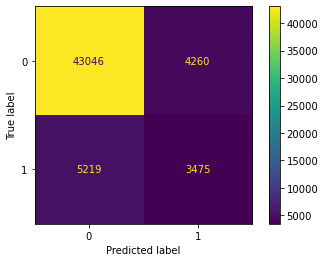

In [211]:
print(confusion_matrix(y_val, y_val_pred))
disp = ConfusionMatrixDisplay(confusion_matrix(y_val, y_val_pred))
disp.plot()

recall: 0.7648578811369509
precision: 0.25234441602728047
f1-score: 0.37948717948717947
[[1004  877]
 [  91  296]]


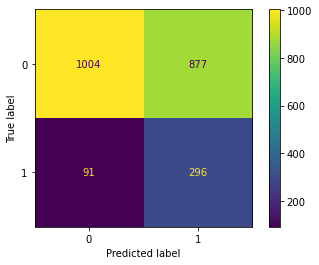

In [89]:
y_real_al_pred = (model.predict(np.expand_dims(X_real_al_inp, axis=-1)) > 0.5).astype(int)

# Print f1, precision, and recall scores
print("recall:", recall_score(y_real_al, y_real_al_pred))
print("precision:", precision_score(y_real_al, y_real_al_pred))
print("f1-score:", f1_score(y_real_al, y_real_al_pred))

print(confusion_matrix(y_real_al, y_real_al_pred))
disp = ConfusionMatrixDisplay(confusion_matrix(y_real_al, y_real_al_pred))
disp.plot()

In [101]:
X_real_ah

0         1         2         3         4         5         6  \
0     0.671756  0.435115  0.572519  0.412214  0.595420  0.244275  0.503817   
1     0.628743  0.634731  0.497006  0.748503  0.952096  0.868263  1.000000   
2     0.820896  1.000000  0.776119  0.970149  0.962687  0.701493  0.925373   
3     0.610294  0.588235  0.573529  0.654412  0.073529  0.000000  0.654412   
4     0.693750  0.650000  0.600000  0.556250  0.612500  0.662500  0.793750   
...        ...       ...       ...       ...       ...       ...       ...   
2067  0.349057  0.245283  0.141509  0.226415  0.122642  0.198113  0.000000   
2068  0.292683  0.422764  0.447154  0.528455  0.666667  0.731707  0.593496   
2069  0.634146  0.967480  0.934959  0.894309  1.000000  0.764228  0.536585   
2070  0.534161  0.621118  0.546584  0.614907  0.372671  0.552795  0.416149   
2071  0.362445  0.545852  0.467249  0.419214  0.301310  0.506550  0.598253   

             7         8         9  ...        23        24        25  \
0     0.419847  0.328244  0.519084  ...  0.717557  0.709924  0.442748   
1     0.215569  0.628743  0.772455  ...  0.532934  0.059880  0.000000   
2     0.791045  0.850746  0.731343  ...  0.589552  0.656716  0.716418   
3     0.088235  0.529412  0.794118  ...  0.867647  0.816176  0.764706   
4     0.862500  0.831250  0.750000  ...  0.406250  0.000000  0.437500   
...        ...       ...       ...  ...       ...       ...       ...   
2067  0.179245  0.216981  0.273585  ...  0.877358  1.000000  0.726415   
2068  0.715447  0.634146  0.447154  ...  0.317073  0.000000  0.235772   
2069  0.439024  0.341463  0.276423  ...  0.292683  0.073171  0.455285   
2070  0.602484  0.434783  0.559006  ...  0.788820  0.956522  1.000000   
2071  0.567686  0.572052  0.458515  ...  0.401747  0.375546  0.344978   

            26        27        28        29  ts_id  win_id  label  
0     0.671756  0.534351  0.595420  0.473282    783       0      0  
1     0.532934  0.071856  0.431138  0.646707    783       1      0  
2     0.873134  0.955224  0.917910  0.820896    783       2      0  
3     0.713235  0.661765  0.772059  0.588235    783       3      0  
4     0.387500  1.000000  0.237500  0.362500    783       4      1  
...        ...       ...       ...       ...    ...     ...    ...  
2067  0.462264  0.349057  0.235849  0.160377  14939      23      0  
2068  0.056911  0.300813  0.081301  0.243902  14939      24      0  
2069  0.626016  0.569106  0.577236  0.365854  14939      25      0  
2070  0.801242  0.000000  0.372671  0.745342  14939      26      0  
2071  0.318777  1.000000  1.000000  1.000000  14939      27      0  

[2072 rows x 33 columns]

recall: 0.7232704402515723
precision: 0.2274975272007913
f1-score: 0.34612490594431905
[[973 781]
 [ 88 230]]


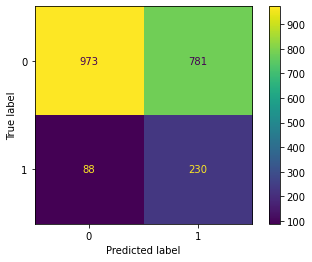

In [90]:
y_real_ah_pred = (model.predict(np.expand_dims(X_real_ah_inp, axis=-1)) > 0.5).astype(int)

# Print f1, precision, and recall scores
print("recall:", recall_score(y_real_ah, y_real_ah_pred))
print("precision:", precision_score(y_real_ah, y_real_ah_pred))
print("f1-score:", f1_score(y_real_ah, y_real_ah_pred))

print(confusion_matrix(y_real_ah, y_real_ah_pred))
disp = ConfusionMatrixDisplay(confusion_matrix(y_real_ah, y_real_ah_pred))
disp.plot()

recall: 0.4699565912725611
precision: 0.4648587570621469
f1-score: 0.4673937741422404
[[21255  2368]
 [ 2320  2057]]


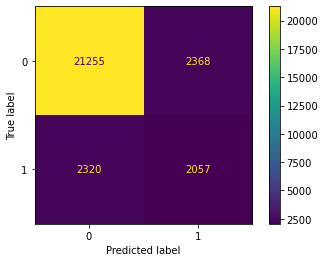

In [76]:
y_test_pred = (model.predict(np.expand_dims(X_test_inp, axis=-1)) > 0.5).astype(int)

# Print f1, precision, and recall scores
print("recall:", recall_score(y_test, y_test_pred))
print("precision:", precision_score(y_test, y_test_pred))
print("f1-score:", f1_score(y_test, y_test_pred))

print(confusion_matrix(y_test, y_test_pred))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred))
disp.plot()

In [121]:
Counter(y_val_pred.reshape(-1)).most_common()

[(0, 44897), (1, 11103)]

In [19]:
Counter(y_test_pred.reshape(-1)).most_common()

[(0.72294444, 2),
 (0.20865831, 2),
 (0.4753374, 2),
 (0.2931645, 2),
 (0.29683095, 2),
 (0.31071612, 2),
 (0.33783373, 2),
 (0.3227417, 2),
 (0.26364833, 2),
 (0.5345881, 2),
 (0.26635504, 2),
 (0.5205546, 2),
 (0.42676625, 2),
 (0.28894106, 2),
 (0.37994203, 2),
 (0.33835927, 2),
 (0.3834813, 2),
 (0.98241454, 2),
 (0.28693378, 2),
 (0.35456073, 2),
 (0.22839239, 2),
 (0.23464428, 2),
 (0.57283264, 2),
 (0.37271398, 2),
 (0.25340596, 2),
 (0.57592154, 2),
 (0.43096146, 2),
 (0.20133567, 2),
 (0.5902489, 2),
 (0.2263512, 2),
 (0.21873723, 2),
 (0.37759823, 2),
 (0.39165947, 2),
 (0.50609565, 2),
 (0.40292126, 2),
 (0.3566991, 2),
 (0.3209639, 2),
 (0.27268845, 2),
 (0.4115033, 2),
 (0.34932783, 2),
 (0.23329243, 2),
 (0.30073735, 2),
 (0.42894158, 2),
 (0.39670238, 2),
 (0.22953895, 2),
 (0.26097938, 2),
 (0.35367084, 2),
 (0.22205295, 2),
 (0.3963556, 2),
 (0.41754794, 2),
 (0.57068986, 2),
 (0.2138182, 2),
 (0.61245537, 2),
 (0.2612195, 2),
 (0.32968765, 2),
 (0.3789582, 2),
 (0.409

In [130]:
Counter(y_train).most_common()

[(0, 141733), (1, 26267)]

In [38]:
## Input the filenames and parameters:
filename = 'segmented_ts_sim_with_UE_02.pkl'
original_indices = 'orig_x.npy'
full_indices = 'full_time_index.npy'
interpolation_method = 'original'

In [39]:
## Create variables with directories to external files:
directory = os.path.join(dirname(os.getcwd()), 'data_files/')
file_data = os.path.join(directory, filename)
file_full_indices = os.path.join(directory, full_indices)
file_orig_indices = os.path.join(directory, original_indices)

In [40]:
## Import the measurements:
data_imported = pd.read_pickle(file_data)
data_df = data_imported['time-series with UE']

## Load and calculate x-axis index:
orig_x = np.load(file_orig_indices)
full_x = np.load(file_full_indices) 
indices = [int(i*365.25/11) for i in orig_x]

## Load the answers (ground truth):
points = pd.DataFrame(data_imported['list of UE'], index = data_imported.index)
points.columns = ['points']
segm_lines = pd.DataFrame(data_imported['segm_lines'], index = data_imported.index)
segm_lines.columns = ['segm_lines']

In [41]:
record_num = len(data_df)
record_length = len(data_df.iloc[0])

## Reshape the data from DataFrame into an array
data = np.zeros((record_num, record_length))
for idx, ar in enumerate(data_df.values):
    data[idx, :] = ar
    data[idx, 0] = 0.0
    
ans_pt = np.zeros((record_num, record_length))
for idx, l in enumerate(points.values):
    for p in l[0]:
        ans_pt[idx, p] = 1
        ans_pt[idx, 0] = 0
        
ans_seg = np.zeros((record_num, record_length))
for idx, l in enumerate(segm_lines.values):
    for s in l[0]:
        ans_seg[idx, s] = 1

In [42]:
window_len = 30
shift = 10
num_of_windows = int(np.ceil((297 - window_len)/shift) + 1) #58
print(num_of_windows)

## Reshape the data from DataFrame into an array

data_divided = np.zeros((data.shape[0], num_of_windows, window_len))
for idx, ar in enumerate(data):recall: 0.4398435702783529
precision: 0.45469678953626635
f1-score: 0.4471468662301216
    for win in range(num_of_windows):
        inp = ar[shift*win: shift*win+window_len]
        data_divided[idx, win, 0:len(inp)] = inp

y_segm_all_divided = np.zeros((data.shape[0], num_of_windows, window_len))
for idx, ar in enumerate(ans_seg):
    for win in range(num_of_windows):
        inp = ar[shift*win: shift*win+window_len]
        y_segm_all_divided[idx, win, 0:len(inp)] = inp

y_segm_divided = np.zeros((data.shape[0], num_of_windows))
for idx, ar in enumerate(ans_seg):
    for win in range(num_of_windows):
        y_segm_divided[idx, win] = max(ar[shift*win: shift*win+window_len])

28


In [79]:
y_val_pred_df = pd.concat([pd.DataFrame(y_val_pred, columns=["label"]), pd.DataFrame(idx_val, columns=["ts_id", "win_id"])], axis=1)


In [49]:
(X_real[X_real["ts_id"] == 14].drop(columns=["ts_id", "win_id", "label"]).values).shape

(28, 30)

In [53]:
(X_real[X_real["ts_id"] == 14]["label"])

0     1
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    1
14    1
15    1
16    0
17    1
18    1
19    1
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
Name: label, dtype: int32

In [55]:

ts_idx = int(X_train.iloc[0]["ts_id"])
ts_idx = 1611
d = data[ts_idx]
dd = data_divided[ts_idx]
y = y_segm_divided[ts_idx]
y_all = y_segm_all_divided[ts_idx]
y_pred = y_test_pred_df[y_test_pred_df["ts_id"] == ts_idx]["label"]

plt.figure(figsize=(30,15))
ax = plt.gca()
for w in range(num_of_windows):
    xs = w*shift
    xe = w*shift + window_len
    ax.plot(range(xs, xe), dd[w], c='b')
    if y[w] == 1:
        ax.axvspan(xs, xe, alpha=0.2, color='red')
    for x, val in enumerate(y_all[w]):
        if val == 1:
            ax.axvline(xs+x, c="black", linestyle="--")
    if y_pred.iloc[w] == 1:
        ax.axvspan(xs, xe, alpha=0.2, color='blue')

NameError: name 'y_test_pred_df' is not defined

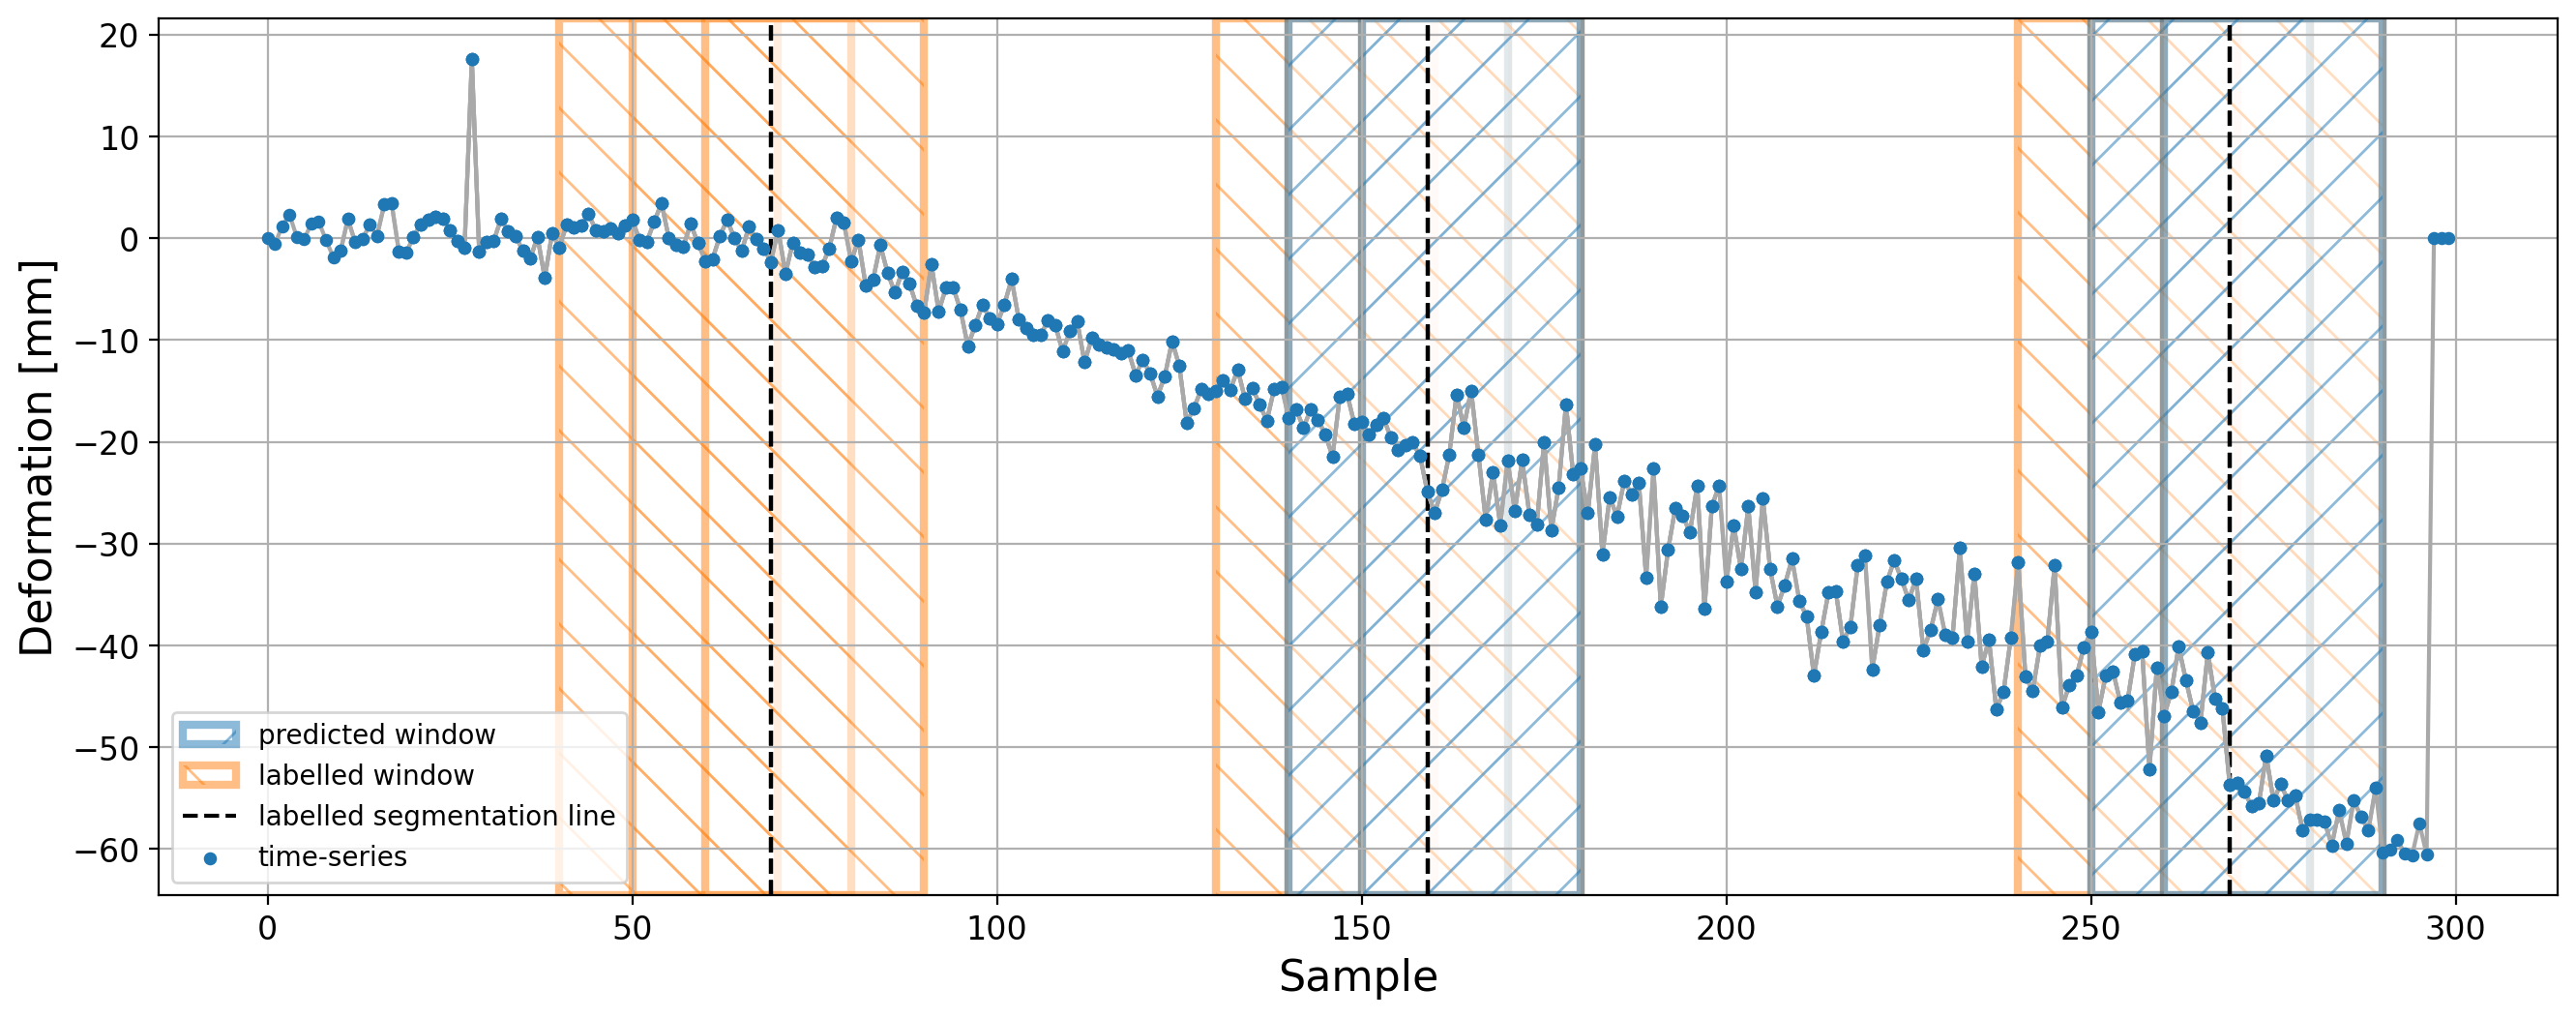

In [287]:
ts_idx = int(X_train.iloc[0]["ts_id"])
ts_idx = 1611
d = data[ts_idx]
dd = data_divided[ts_idx]
y = y_segm_divided[ts_idx]
y_all = y_segm_all_divided[ts_idx]
y_pred = y_val_pred_df[y_val_pred_df["ts_id"] == ts_idx]["label"]

fig = plt.figure(figsize=(16,6), dpi=200)
ax = plt.gca()
for w in range(num_of_windows):
    xs = w*shift
    xe = w*shift + window_len
    ax.plot(range(xs, xe), dd[w], c='darkgrey', zorder=3)
    tl = ax.scatter(range(xs, xe), dd[w], c='tab:blue', zorder=4, s=15, label="time-series")
    if y[w] == 1:
#         ax.axvspan(xs, xe, alpha=0.1, hatch="\\", color='red')
        gt_area = ax.axvspan(xs, xe, alpha=0.5, facecolor="white", edgecolor="tab:orange", hatch="\\", linewidth=3, label="labelled window")
    for x, val in enumerate(y_all[w]):
        if val == 1:
            gt_line = ax.axvline(xs+x, c="black", linestyle="--", label="labelled segmentation line")
    if y_pred.iloc[w] == 1:
#         ax.axvspan(xs, xe, alpha=0.1, hatch="/", color='blue', linewidth=3)
        pred_area = ax.axvspan(xs, xe, alpha=0.5, facecolor="white", edgecolor="tab:blue", hatch="/", linewidth=3, label="predicted window")
plt.grid()
plt.xlabel("Sample", fontsize = 16)
plt.ylabel("Deformation [mm]", fontsize = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(handles=[pred_area, gt_area, gt_line, tl])
plt.show()

fig.tight_layout()
# fig.savefig(f'subs_example_cnn_06b.jpg', bbox_inches="tight")

In [ ]:
from matplotlib.patches import Rectangle

num_of_lines = randint(0,3)
print(num_of_lines)
seg_line_ind = []
shortest_seg = 15
available_range = [x for x in range(shortest_seg, 296-shortest_seg)]
plt.figure(figsize=(10, 5))
plt.scatter(available_range, np.zeros(len(available_range)))
for i in range(0, num_of_lines):    
    seg_line_ind_tmp = np.random.choice(available_range)
    available_range = [x for x in available_range if np.abs(x-seg_line_ind_tmp)>shortest_seg]
#     print(available_range)
    plt.scatter(seg_line_ind_tmp, i, c='black')
    plt.vlines(seg_line_ind_tmp-15, i, num_of_lines, linestyle='--', color='darkgray')
    plt.vlines(seg_line_ind_tmp+15, i, num_of_lines, linestyle='--', color='darkgray')
    plt.gca().add_patch(Rectangle((seg_line_ind_tmp-15, i), 30, num_of_lines-i, alpha=0.2, fc="grey", hatch="x"))
    plt.scatter(available_range, np.ones(len(available_range))+ i, c="tab:blue")
    seg_line_ind.append(seg_line_ind_tmp)
    print(seg_line_ind)
plt.xticks([0, 50, 100, 150, 200, 250, 300])
plt.yticks(np.arange(0, num_of_lines+1, 1))
plt.ylabel("Segmentation line", fontsize=16)
plt.xlabel("Sample", fontsize=16)
seg_line_ind = sorted(seg_line_ind)
seg_t = seg_line_ind
seg_t.insert(0, 0)
seg_t.append(len(t))

plt.gcf().tight_layout()

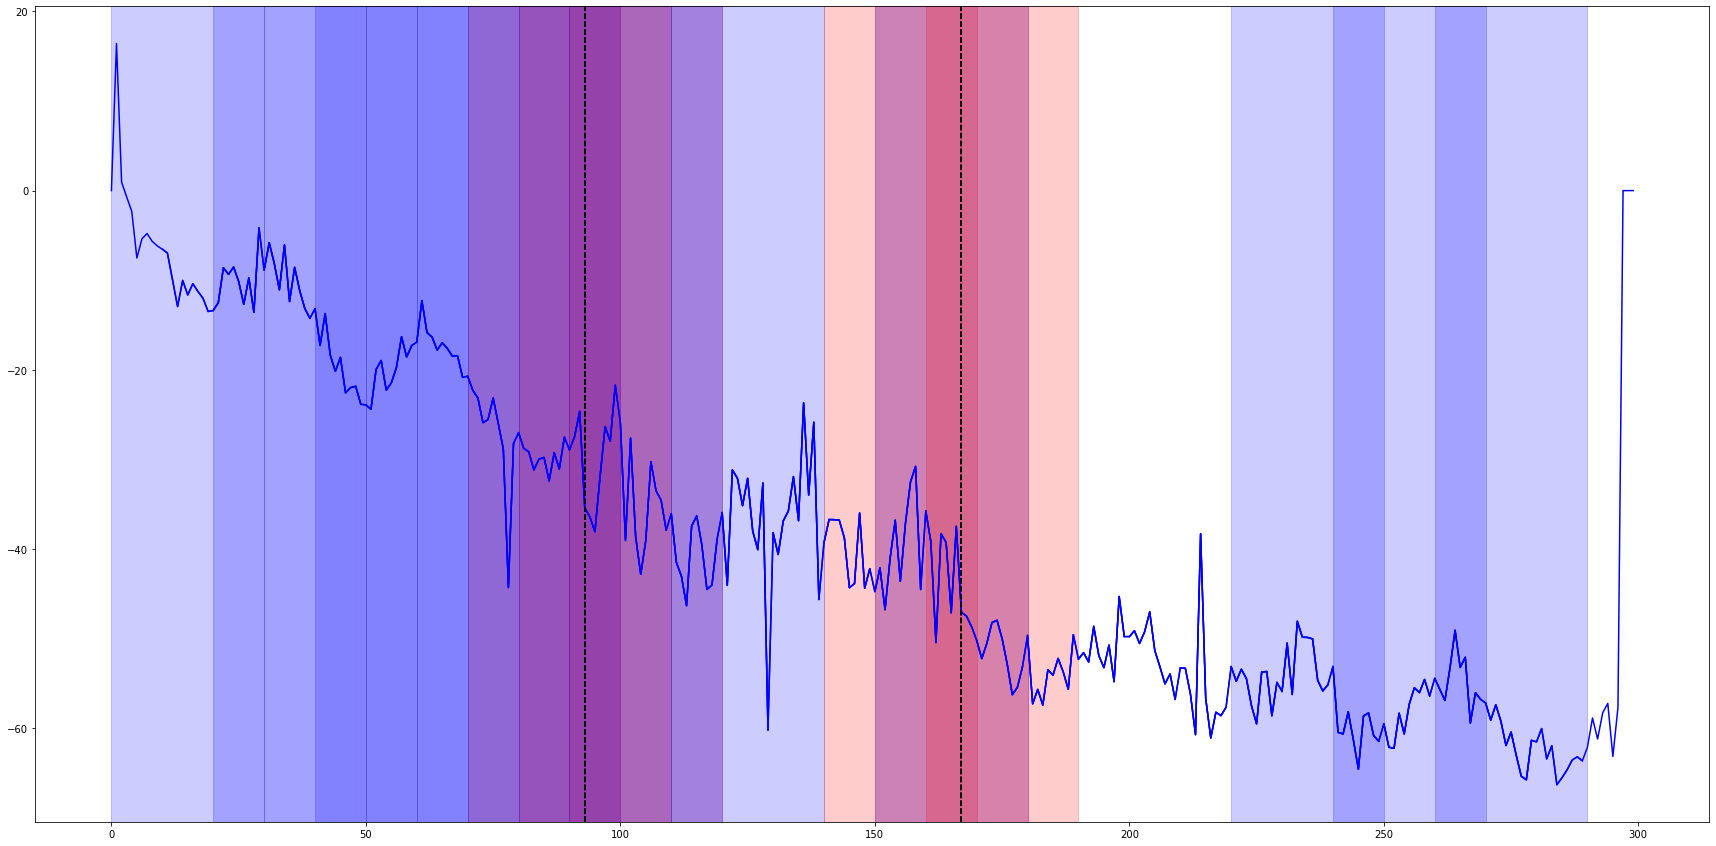

In [110]:
ts_idx = 3
d = data[ts_idx]
dd = data_divided[ts_idx]
y = y_segm_divided[ts_idx]
y_all = y_segm_all_divided[ts_idx]
y_pred = y_test_pred_df[y_test_pred_df["ts_id"] == ts_idx]["label"]

plt.figure(figsize=(30,15))
ax = plt.gca()
for w in range(num_of_windows):
    xs = w*shift
    xe = w*shift + window_len
    ax.plot(range(xs, xe), dd[w], c='b')
    if y[w] == 1:
        ax.axvspan(xs, xe, alpha=0.2, color='red')
    for x, val in enumerate(y_all[w]):
        if val == 1:
            ax.axvline(xs+x, c="black", linestyle="--")
    if y_pred.iloc[w] == 1:
        ax.axvspan(xs, xe, alpha=0.2, color='blue')

## Real data

In [173]:
with open("raw_real_input_data_ans_seg.pkl", "rb") as file:
    raw_real_input = pickle.load(file)
    
data_real = raw_real_input["data"]
ans_seg_real = raw_real_input["ans_seg"]

y_segm_all= np.zeros((ans_seg_real.shape[0], num_of_windows, window_len))
for idx, ar in enumerate(ans_seg_real):
    for win in range(num_of_windows):
        inp = ar[shift*win: shift*win+window_len]
        y_segm_all[idx, win, 0:len(inp)] = inp

In [174]:
y_real_al_pred_df = pd.concat([pd.DataFrame(y_real_al_pred, columns=["label"]), pd.DataFrame(idx_real_al, columns=["ts_id", "win_id"])], axis=1)

In [258]:
ts_num_gen = iter(range(0,100))

20 2271


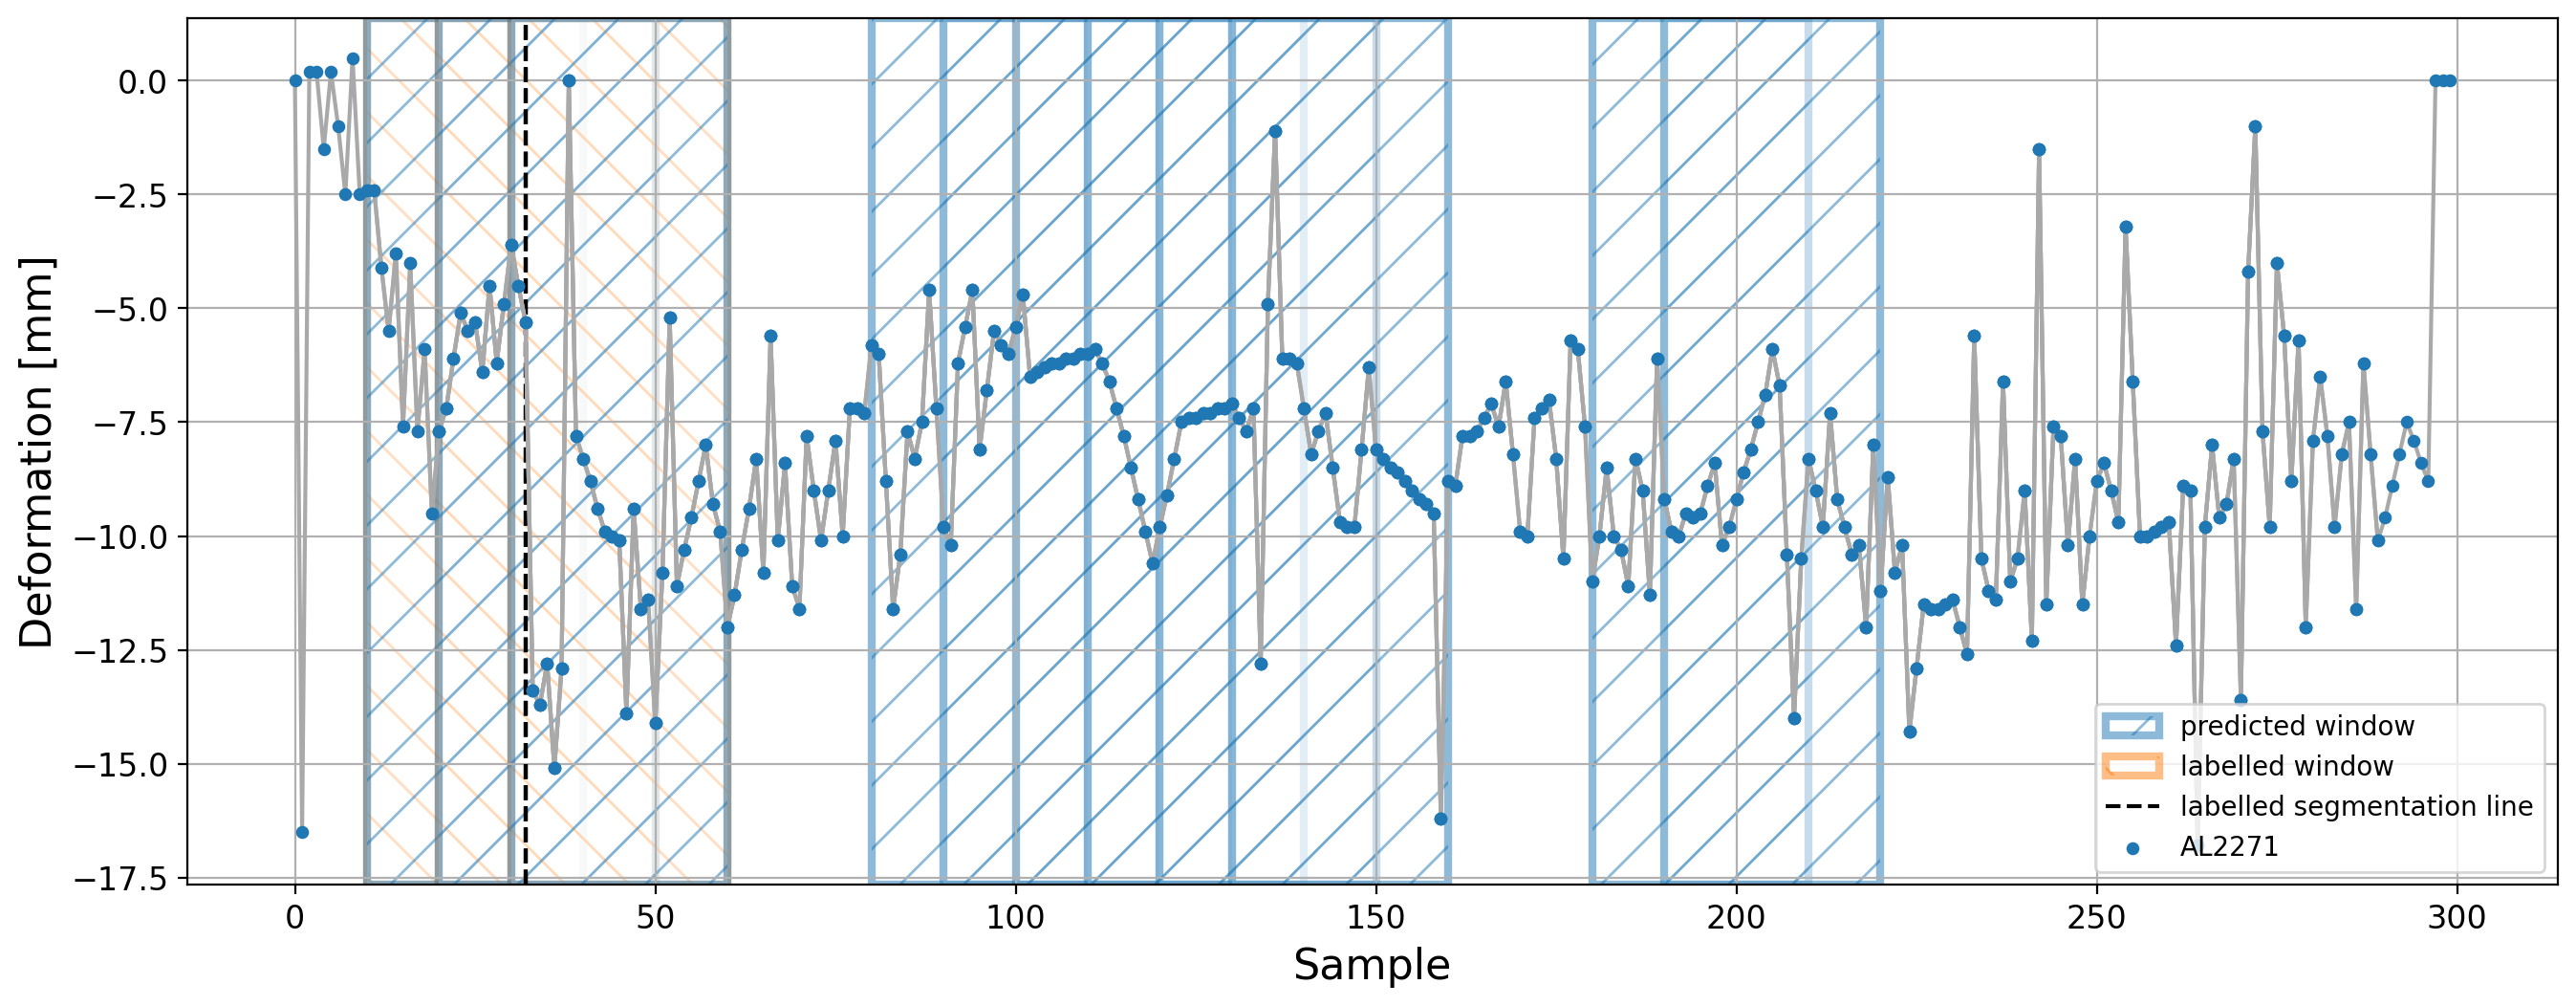

In [286]:
ts_num = 20 #next(ts_num_gen)
ts_idx = int(X_real_al.iloc[ts_num*28]["ts_id"])
print(ts_num, ts_idx)
d = data_real[ts_num]
dd = (X_real_al_load[X_real_al["ts_id"] == ts_idx].drop(columns=["ts_id", "win_id", "label"]).values)
y = (X_real_al[X_real_al["ts_id"] == ts_idx]["label"]).values
y_all = y_segm_all[ts_num]
y_pred = y_real_pred_df[y_real_pred_df["ts_id"] == ts_idx]["label"]

fig = plt.figure(figsize=(16,6), dpi=200)
ax = plt.gca()
for w in range(num_of_windows):
    xs = w*shift
    xe = w*shift + window_len
    ax.plot(range(xs, xe), dd[w], c='darkgrey', zorder=3)
    tl = ax.scatter(range(xs, xe), dd[w], c='tab:blue', zorder=4, s=15, label="AL2271")
    if y[w] == 1:
#         ax.axvspan(xs, xe, alpha=0.1, hatch="\\", color='red')
        gt_area = ax.axvspan(xs, xe, alpha=0.5, facecolor="white", edgecolor="tab:orange", hatch="\\", linewidth=3, label="labelled window")
    for x, val in enumerate(y_all[w]):
        if val == 1:
            gt_line = ax.axvline(xs+x, c="black", linestyle="--", label="labelled segmentation line")
    if y_pred.iloc[w] == 1:
#         ax.axvspan(xs, xe, alpha=0.1, hatch="/", color='blue', linewidth=3)
        pred_area = ax.axvspan(xs, xe, alpha=0.5, facecolor="white", edgecolor="tab:blue", hatch="/", linewidth=3, label="predicted window")
plt.grid()
plt.xlabel("Sample", fontsize = 16)
plt.ylabel("Deformation [mm]", fontsize = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(handles=[pred_area, gt_area, gt_line, tl])
plt.show()

fig.tight_layout()
# fig.savefig(f'subs_example_cnn_real_al_20.jpg', bbox_inches="tight")

In [93]:
with open("raw_real_input_data_ans_seg_ah.pkl", "rb") as file:
    raw_real_input = pickle.load(file)
    
data_real = raw_real_input["data"]
ans_seg_real = raw_real_input["ans_seg"]

y_segm_all= np.zeros((ans_seg_real.shape[0], num_of_windows, window_len))
for idx, ar in enumerate(ans_seg_real):
    for win in range(num_of_windows):
        inp = ar[shift*win: shift*win+window_len]
        y_segm_all[idx, win, 0:len(inp)] = inp

In [102]:
y_real_ah_pred_df = pd.concat([pd.DataFrame(y_real_ah_pred, columns=["label"]), pd.DataFrame(idx_real_ah, columns=["ts_id", "win_id"])], axis=1)

14188


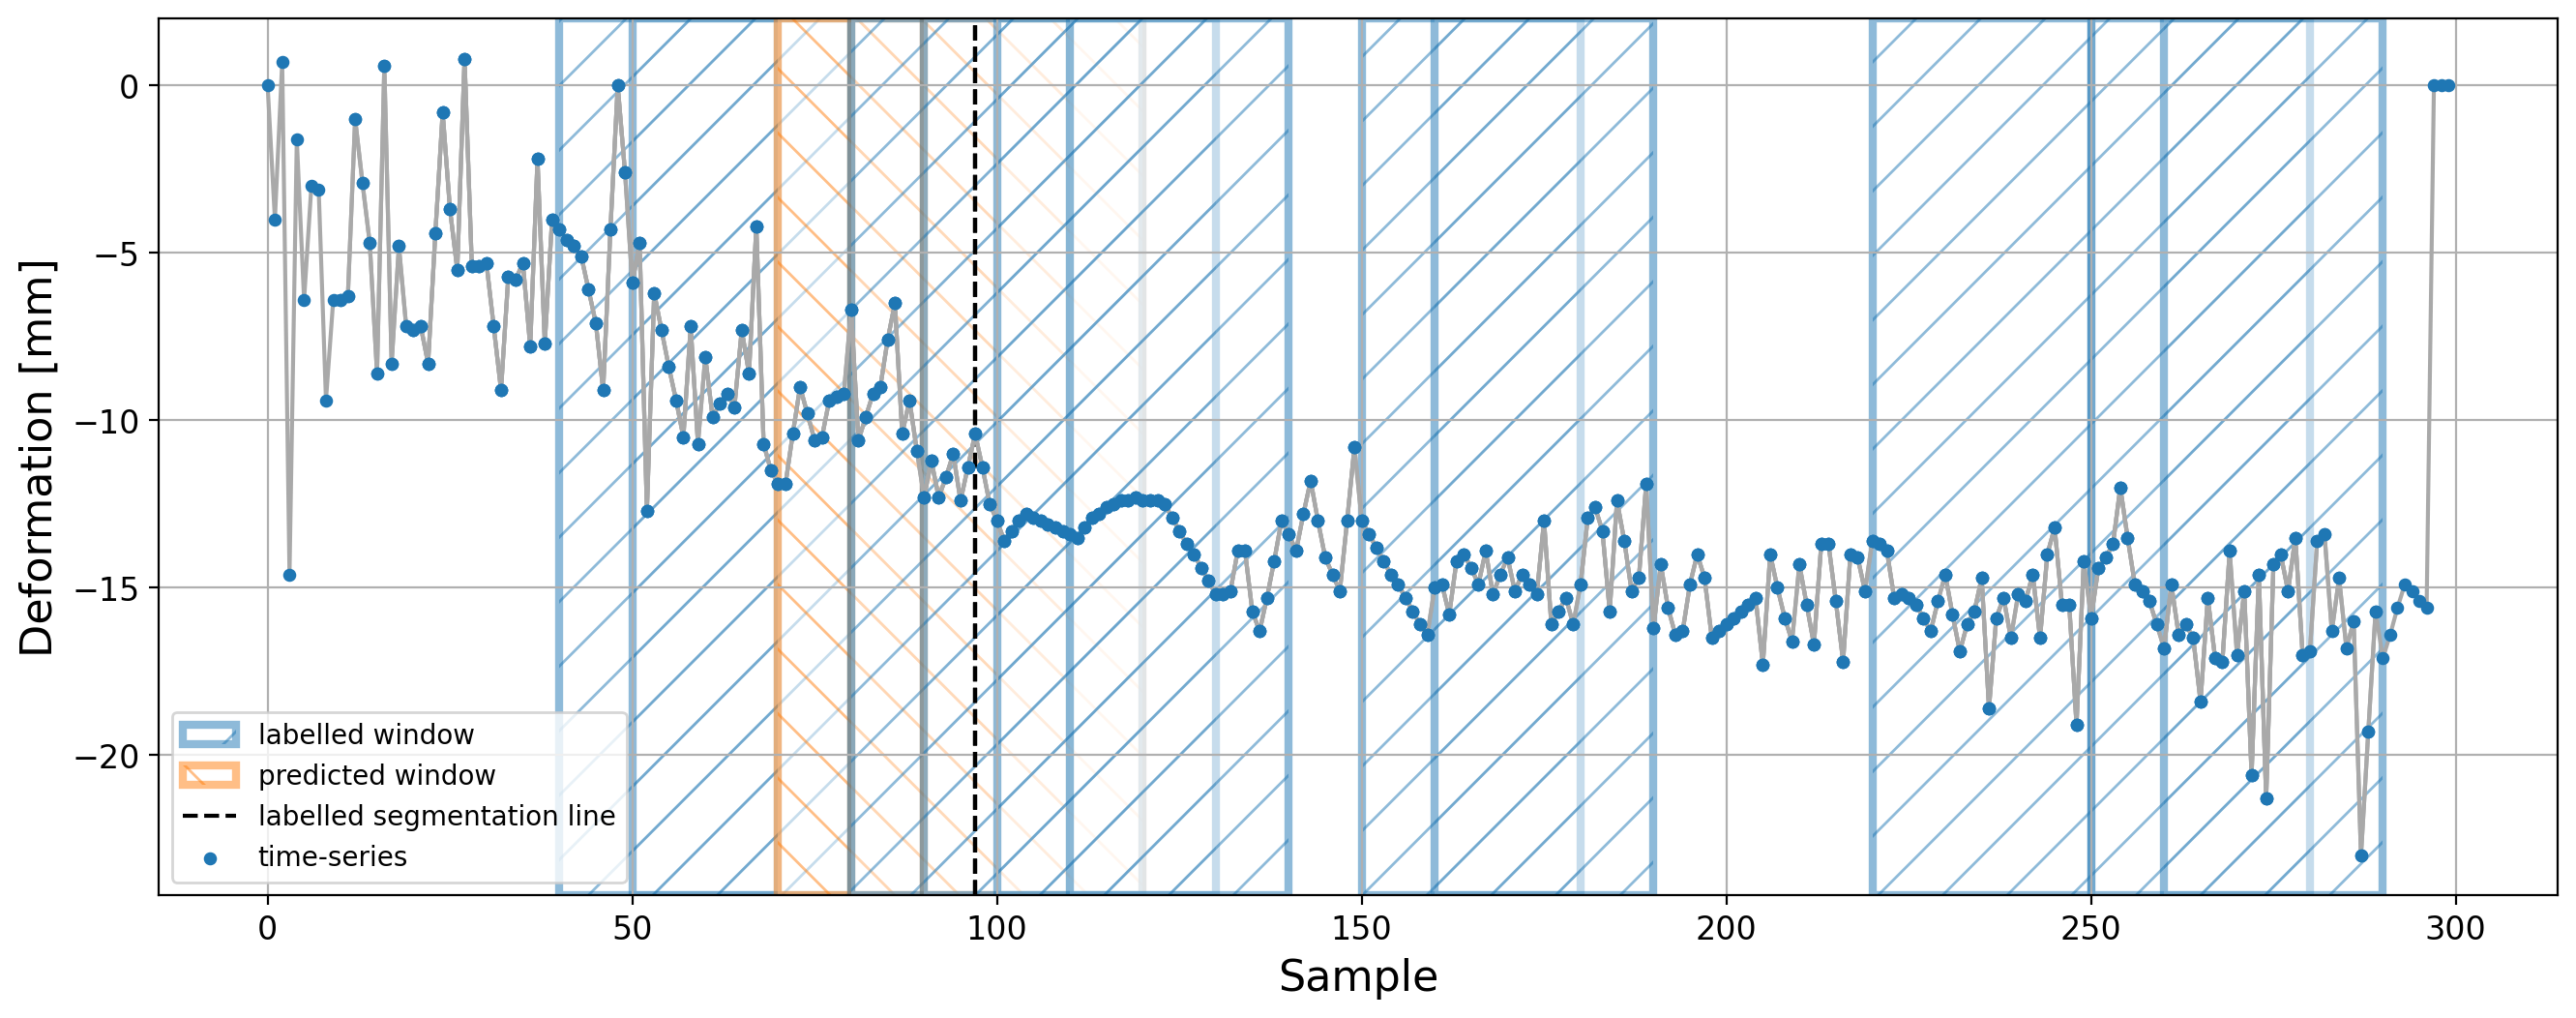

In [167]:
ts_num = 69
ts_idx = int(X_real_ah.iloc[ts_num*28]["ts_id"])
print(ts_idx)
d = data_real[ts_num]
dd = (X_real_ah_load[X_real_ah["ts_id"] == ts_idx].drop(columns=["ts_id", "win_id", "label"]).values)
y = (X_real_ah[X_real_ah["ts_id"] == ts_idx]["label"]).values
y_all = y_segm_all[ts_num]
y_pred = y_real_ah_pred_df[y_real_ah_pred_df["ts_id"] == ts_idx]["label"]

fig = plt.figure(figsize=(16,6), dpi=200)
ax = plt.gca()
for w in range(num_of_windows):
    xs = w*shift
    xe = w*shift + window_len
    ax.plot(range(xs, xe), dd[w], c='darkgrey', zorder=3)
    tl = ax.scatter(range(xs, xe), dd[w], c='tab:blue', zorder=4, s=15, label="time-series")
    if y[w] == 1:
#         ax.axvspan(xs, xe, alpha=0.1, hatch="\\", color='red')
        pred_area = ax.axvspan(xs, xe, alpha=0.5, facecolor="white", edgecolor="tab:orange", hatch="\\", linewidth=3, label="predicted window")
    for x, val in enumerate(y_all[w]):
        if val == 1:
            gt_line = ax.axvline(xs+x, c="black", linestyle="--", label="labelled segmentation line")
    if y_pred.iloc[w] == 1:
#         ax.axvspan(xs, xe, alpha=0.1, hatch="/", color='blue', linewidth=3)
        gt_area = ax.axvspan(xs, xe, alpha=0.5, facecolor="white", edgecolor="tab:blue", hatch="/", linewidth=3, label="labelled window")
plt.grid()
plt.xlabel("Sample", fontsize = 16)
plt.ylabel("Deformation [mm]", fontsize = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(handles=[gt_area, pred_area, gt_line, tl])
plt.show()

fig.tight_layout()
# fig.savefig(f'subs_example_cnn_01.jpg', bbox_inches="tight")